In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import joblib
from xgboost import XGBClassifier

#TODO: Load and preprocess the dataset
url = "https://raw.githubusercontent.com/4GeeksAcademy/decision-tree-project-tutorial/main/diabetes.csv"
data = pd.read_csv(url)

data.shape

(768, 9)

In [2]:
for col in ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']:
    data[col] = data[col].replace(0, data[col][data[col] != 0].median())


In [3]:
# Feature engineering: Add interaction and polynomial features for key variables
data['Glucose_BMI'] = data['Glucose'] * data['BMI']
data['Glucose_Age'] = data['Glucose'] * data['Age']
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(data[['Glucose', 'BMI']])
poly_cols = ['Glucose^2', 'Glucose*BMI_poly', 'BMI^2']
data[poly_cols] = poly_features[:, [0, 1, 3]]  # Select relevant polynomial terms

In [4]:
# Prepare features and target
X = data.drop('Outcome', axis=1)
y = data['Outcome']

# Split the data (stratified to maintain class balance)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
#TODO: Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
#TODO: Build and optimize XGBoost with advanced tuning
# Define parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

# Initialize XGBoost
xgb = XGBClassifier(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

In [7]:
# Fit GridSearchCV
grid_search.fit(X_train_scaled, y_train)

# Train best model
best_params = grid_search.best_params_
best_xgb = XGBClassifier(
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    random_state=42,
    n_jobs=-1
)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits



Optimized XGBoost Model:
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.7}
Accuracy: 0.7208
ROC AUC: 0.6828
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.81      0.79       100
           1       0.61      0.56      0.58        54

    accuracy                           0.72       154
   macro avg       0.69      0.68      0.69       154
weighted avg       0.72      0.72      0.72       154



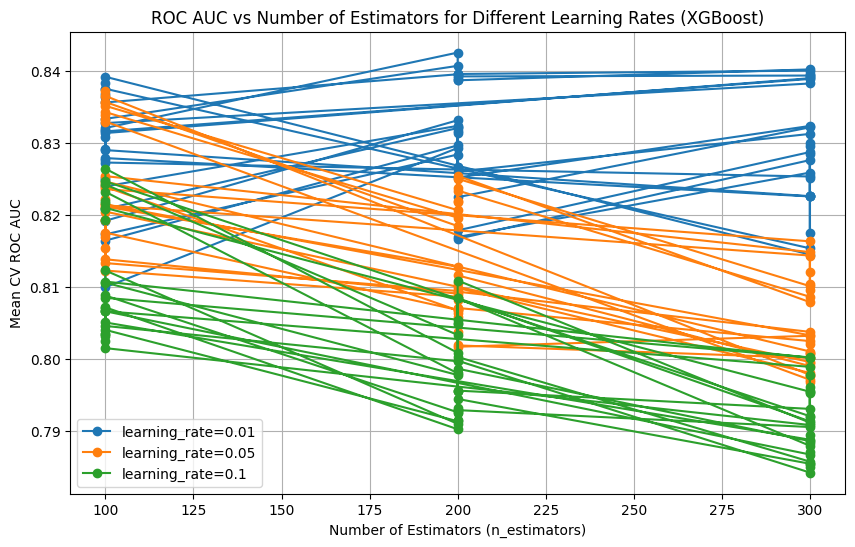

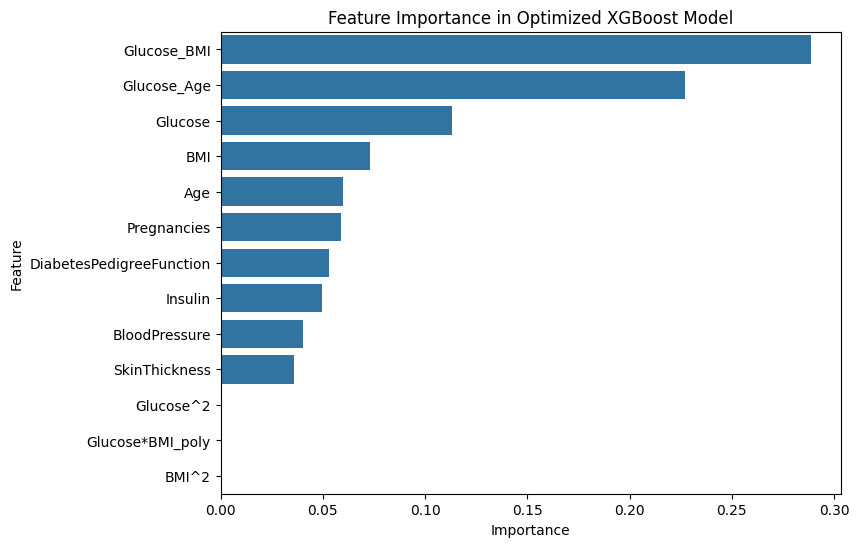

In [8]:
# Fit without early stopping to ensure compatibility
best_xgb.fit(X_train_scaled, y_train)

# Evaluate best model
y_pred_best_xgb = best_xgb.predict(X_test_scaled)
xgb_accuracy = accuracy_score(y_test, y_pred_best_xgb)
xgb_roc_auc = roc_auc_score(y_test, y_pred_best_xgb)

print("\nOptimized XGBoost Model:")
print(f"Best Parameters: {best_params}")
print(f"Accuracy: {xgb_accuracy:.4f}")
print(f"ROC AUC: {xgb_roc_auc:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_best_xgb))

# Visualize hyperparameter impact (using partial results from grid search)
# Extract results for visualization (focus on n_estimators and learning_rate)
results = pd.DataFrame(grid_search.cv_results_)
results['param_n_estimators'] = results['param_n_estimators'].astype(int)
results['param_learning_rate'] = results['param_learning_rate'].astype(float)

plt.figure(figsize=(10, 6))
for lr in param_grid['learning_rate']:
    subset = results[results['param_learning_rate'] == lr]
    plt.plot(subset['param_n_estimators'], subset['mean_test_score'], marker='o', label=f'learning_rate={lr}')
plt.xlabel('Number of Estimators (n_estimators)')
plt.ylabel('Mean CV ROC AUC')
plt.title('ROC AUC vs Number of Estimators for Different Learning Rates (XGBoost)')
plt.legend()
plt.grid(True)
plt.savefig('xgb_roc_auc_vs_n_estimators.png')
plt.show()

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_xgb.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance in Optimized XGBoost Model')
plt.savefig('xgb_feature_importance.png')
plt.show()


In [9]:
#TODO: Save the model
joblib.dump(best_xgb, 'diabetes_xgboost_optimized_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
print("\nOptimized XGBoost model and scaler saved as 'diabetes_xgboost_optimized_model.pkl' and 'scaler.pkl'")



Optimized XGBoost model and scaler saved as 'diabetes_xgboost_optimized_model.pkl' and 'scaler.pkl'



Model Comparison:
               Model  Accuracy   ROC AUC
0      Decision Tree  0.727273  0.657963
1      Random Forest  0.727273  0.687778
2  Optimized XGBoost  0.720779  0.682778


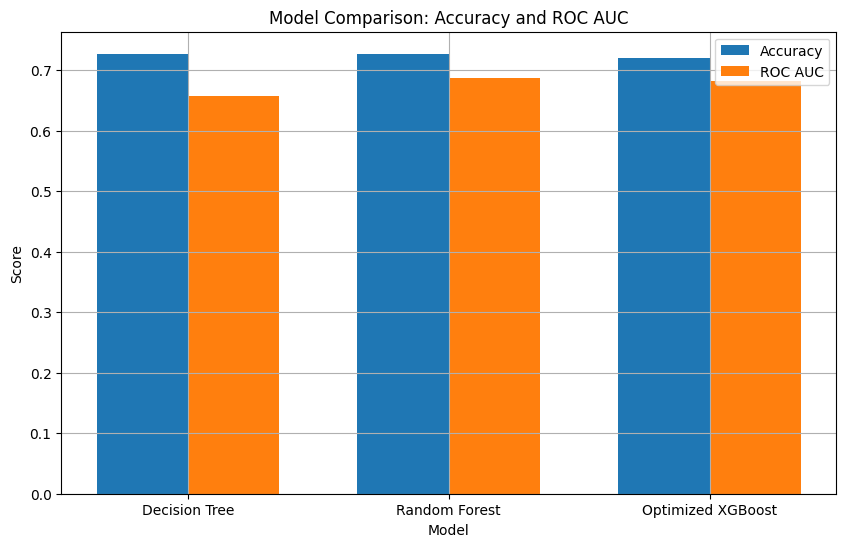


Class-wise Performance (Classification Reports):

Decision Tree:
              precision    recall  f1-score   support

           0       0.74      0.89      0.81       100
           1       0.68      0.43      0.52        54

    accuracy                           0.73       154
   macro avg       0.71      0.66      0.67       154
weighted avg       0.72      0.73      0.71       154


Random Forest:
              precision    recall  f1-score   support

           0       0.77      0.82      0.80       100
           1       0.62      0.56      0.59        54

    accuracy                           0.73       154
   macro avg       0.70      0.69      0.69       154
weighted avg       0.72      0.73      0.72       154


Optimized XGBoost:
              precision    recall  f1-score   support

           0       0.77      0.81      0.79       100
           1       0.61      0.56      0.58        54

    accuracy                           0.72       154
   macro avg       0.69   

In [11]:
#TODO: Compare models (Decision Tree, Random Forest, XGBoost)
# Train Decision Tree (from previous project)
dt = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=42)
dt.fit(X_train_scaled, y_train)
y_pred_dt = dt.predict(X_test_scaled)
dt_accuracy = accuracy_score(y_test, y_pred_dt)
dt_roc_auc = roc_auc_score(y_test, y_pred_dt)

# Train Random Forest (from previous project)
rf = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42, n_jobs=-1)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_roc_auc = roc_auc_score(y_test, y_pred_rf)

# Compile results
model_results = pd.DataFrame({
    'Model': ['Decision Tree', 'Random Forest', 'Optimized XGBoost'],
    'Accuracy': [dt_accuracy, rf_accuracy, xgb_accuracy],
    'ROC AUC': [dt_roc_auc, rf_roc_auc, xgb_roc_auc]
})

# Print comparison
print("\nModel Comparison:")
print(model_results)

# Visualize comparison
plt.figure(figsize=(10, 6))
x = np.arange(len(model_results['Model']))
width = 0.35
plt.bar(x - width/2, model_results['Accuracy'], width, label='Accuracy')
plt.bar(x + width/2, model_results['ROC AUC'], width, label='ROC AUC')
plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Model Comparison: Accuracy and ROC AUC')
plt.xticks(x, model_results['Model'])
plt.legend()
plt.grid(True)
plt.savefig('model_comparison.png')
plt.show()

# Analyze class-wise performance
print("\nClass-wise Performance (Classification Reports):")
print("\nDecision Tree:")
print(classification_report(y_test, y_pred_dt))
print("\nRandom Forest:")
print(classification_report(y_test, y_pred_rf))
print("\nOptimized XGBoost:")
print(classification_report(y_test, y_pred_best_xgb))

# Model selection
best_model = model_results.loc[model_results['ROC AUC'].idxmax(), 'Model']
print(f"\nSelected Model: {best_model} (based on highest ROC AUC)")